In [22]:
!pip install scikit-learn tensorflow opencv-python imutils

In [4]:
!pip install kagglehub

In [ ]:
//installation des dependances

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Resuming download from 187695104 bytes (520477486 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/iarunava/cell-images-for-detecting-malaria?dataset_version_number=1 (187695104/708172590) bytes left.


100%|████████████████████████████████████████| 675M/675M [03:29<00:00, 2.48MB/s]

Extracting files...


Path to dataset files: /Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


## Input

In [28]:
import os

# dataset_path = "/root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images"
dataset_path="/Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images"
# Check if the dataset path exists
if os.path.exists(dataset_path):
    print(f"Dataset path exists: {dataset_path}")
else:
    print(f"Dataset path does not exist: {dataset_path}")

# Check the contents of the dataset path
print(f"Contents of dataset path:\n{os.listdir(dataset_path)}")

Dataset path exists: /Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images
Contents of dataset path:
['Parasitized', 'Uninfected', 'cell_images']


In [30]:

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

def preprocess_and_visualize(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            return None, None, None # Return three values (None, None, None)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Calculate histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

        # Calculate image features (example: mean pixel value)
        mean_pixel_value = np.mean(gray)

        return img, hist, mean_pixel_value
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None # Return three values (None, None, None)

In [32]:
image_paths = []
for class_folder in os.listdir(dataset_path):
  class_folder_path = os.path.join(dataset_path, class_folder)
  if os.path.isdir(class_folder_path):
      for image_file in os.listdir(class_folder_path)[:5]: #process only 5 images per class
          image_paths.append(os.path.join(class_folder_path, image_file))





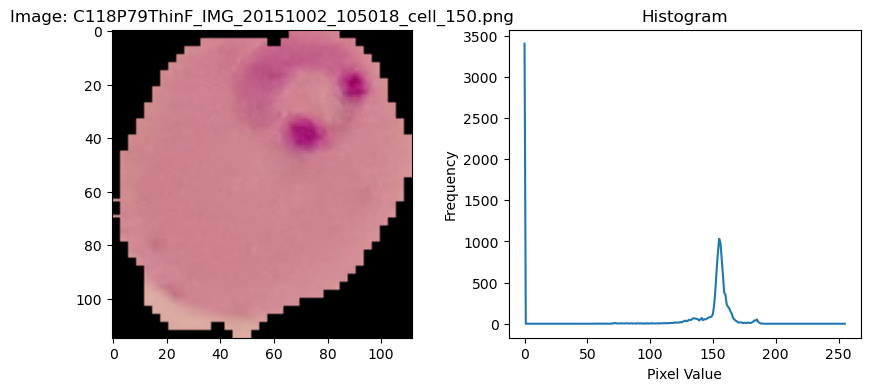

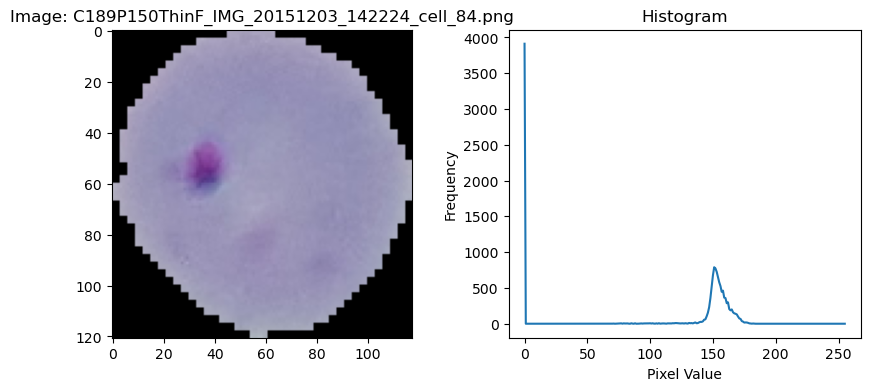

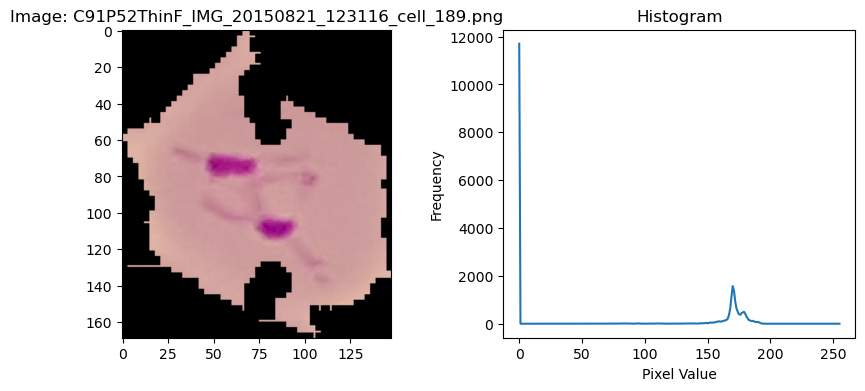

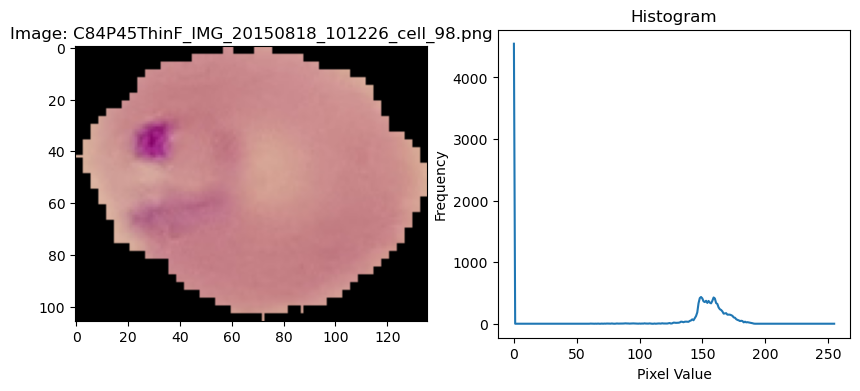

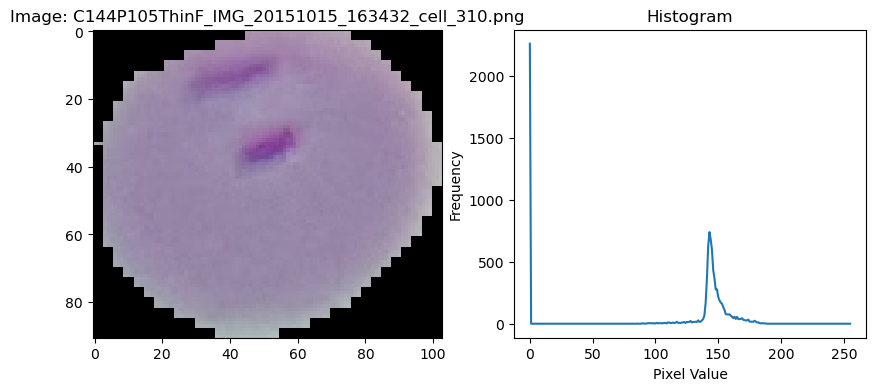

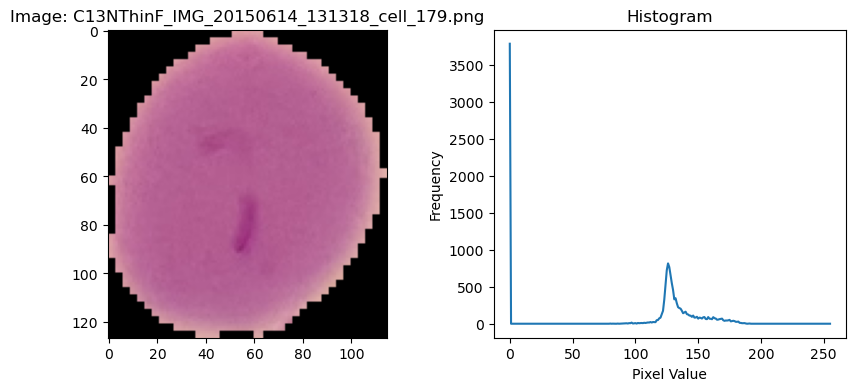

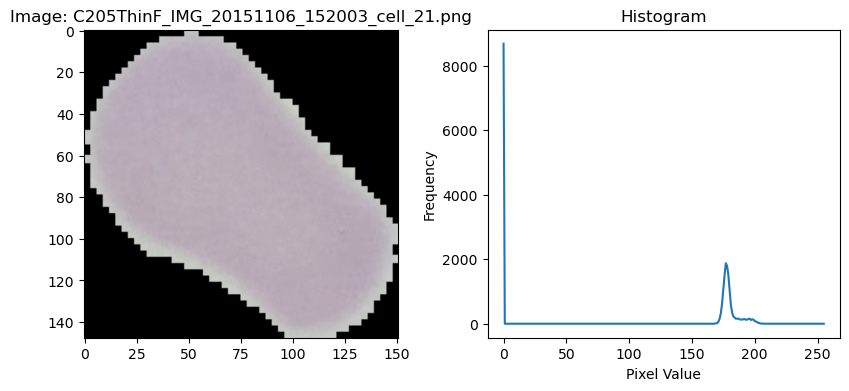

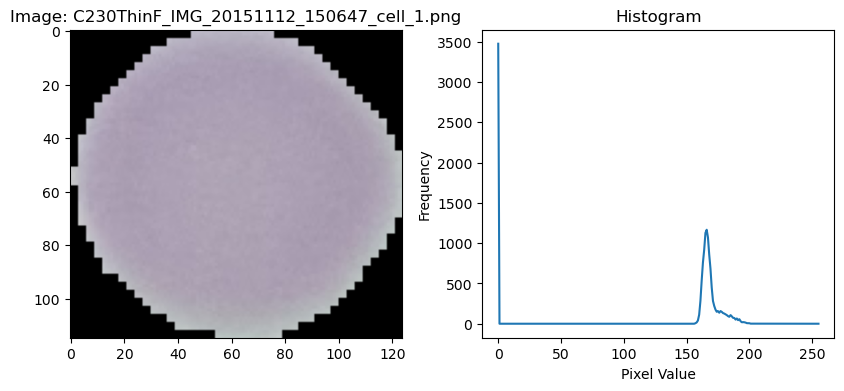

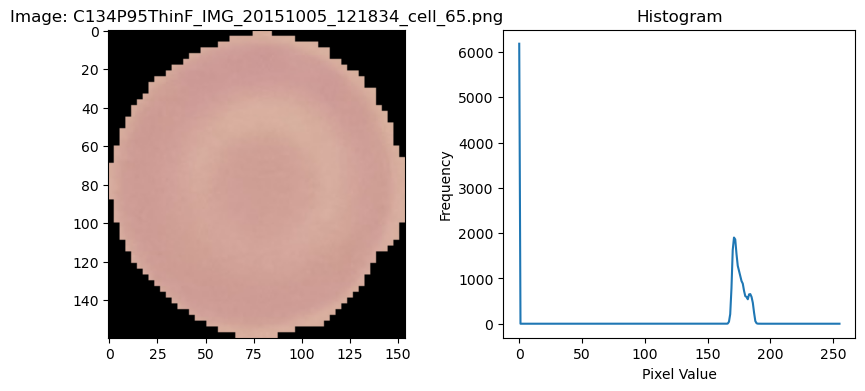

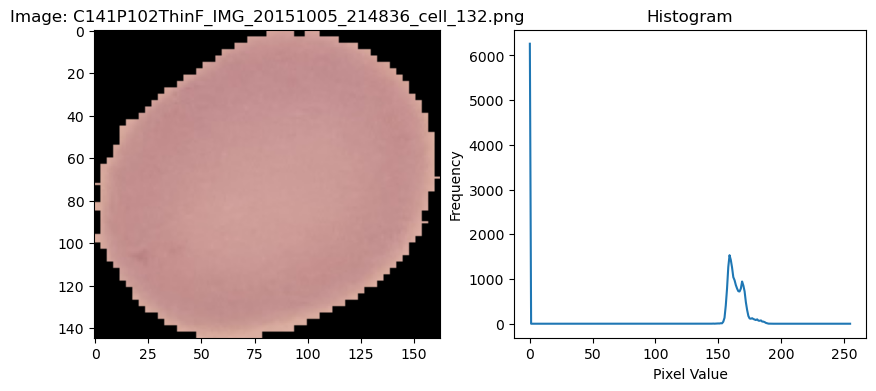

Could not read image: /Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized
Could not read image: /Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected


In [34]:

pixel_values = []

for image_path in image_paths:
    img, hist, mean_pixel = preprocess_and_visualize(image_path)
    if img is not None:
        pixel_values.append(mean_pixel)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Image: {os.path.basename(image_path)}")

        plt.subplot(1, 2, 2)
        plt.plot(hist)
        plt.title("Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        plt.show()


In [36]:
pixel_values_parasitized = []
pixel_values_uninfected = []

for image_path in image_paths:
    img, hist, mean_pixel = preprocess_and_visualize(image_path)
    if img is not None:
        # Get class label from image path
        class_label = os.path.basename(os.path.dirname(image_path))

        if class_label == "Parasitized":
            pixel_values_parasitized.append(mean_pixel)
        elif class_label == "Uninfected":
            pixel_values_uninfected.append(mean_pixel)

Could not read image: /Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Parasitized
Could not read image: /Users/mac/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/cell_images/Uninfected


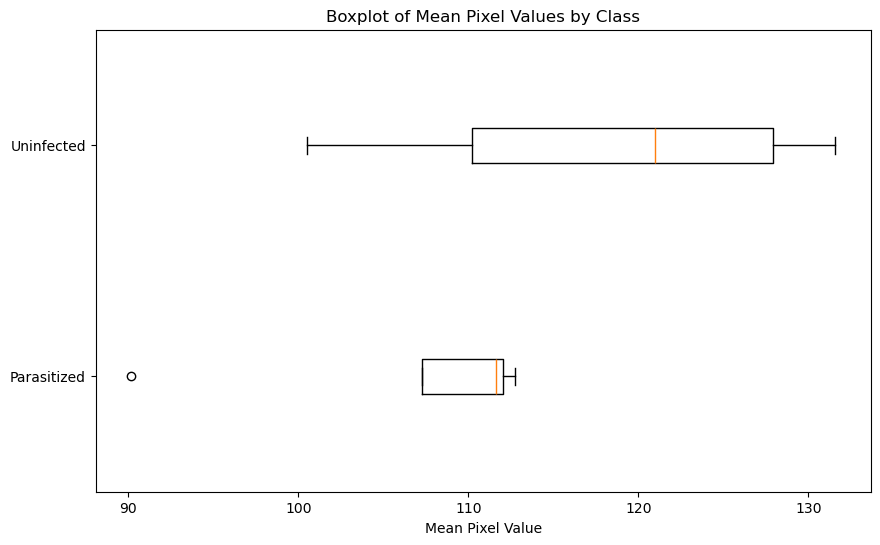

In [38]:
plt.figure(figsize=(10, 6))
plt.boxplot([pixel_values_parasitized, pixel_values_uninfected],
            labels=["Parasitized", "Uninfected"], vert=False)
plt.title("Boxplot of Mean Pixel Values by Class")
plt.xlabel("Mean Pixel Value")
plt.show()

In [40]:
parasitized_count = 0
uninfected_count = 0

if os.path.exists(dataset_path):
    for class_folder in os.listdir(dataset_path):
        class_folder_path = os.path.join(dataset_path, class_folder)
        if os.path.isdir(class_folder_path):
            if class_folder == "Parasitized":
                parasitized_count = len(os.listdir(class_folder_path))
            elif class_folder == "Uninfected":
                uninfected_count = len(os.listdir(class_folder_path))

    print(f"Number of parasitized images: {parasitized_count}")
    print(f"Number of uninfected images: {uninfected_count}")
else:
    print(f"Dataset path does not exist: {dataset_path}")


Number of parasitized images: 13780
Number of uninfected images: 13780


In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


# Assuming pixel_values_parasitized and pixel_values_uninfected are populated
# and you have corresponding labels (0 for uninfected, 1 for parasitized)

# Create labels
labels = [1] * len(pixel_values_parasitized) + [0] * len(pixel_values_uninfected)

# Combine pixel values
pixel_values_combined = pixel_values_parasitized + pixel_values_uninfected

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pixel_values_combined, labels, test_size=0.2, random_state=42
)

# Reshape the data for the model (add a dimension for the single feature)
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create a simple sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)), # Input layer with one feature
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10)  # Adjust the number of epochs as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")




2025-03-09 16:28:41.277022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 0.5000 - loss: 32.4598
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 32.2724
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 32.0851
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 31.8981
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5000 - loss: 31.7113
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5000 - loss: 31.5247
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5000 - loss: 31.3383
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5000 - loss: 31.1522
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5000 - loss: 30.9663
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5000 - loss: 30.7807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5000 - loss: 32.5039
Test Loss: 32.503902435302734
Test Accuracy: 0.5


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5000 - loss: 30.4170 - val_accuracy: 0.5000 - val_loss: 30.9418
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5000 - loss: 30.2330 - val_accuracy: 0.5000 - val_loss: 30.7538
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5000 - loss: 30.0493 - val_accuracy: 0.5000 - val_loss: 30.5661
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5000 - loss: 29.8659 - val_accuracy: 0.5000 - val_loss: 30.3787


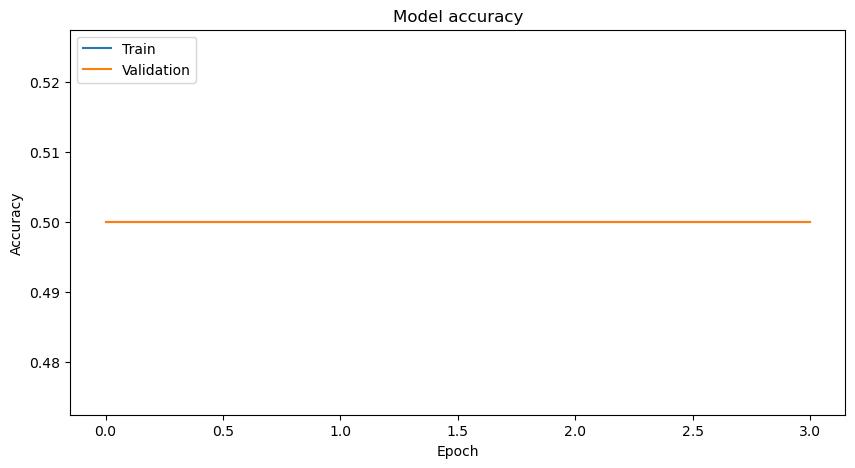

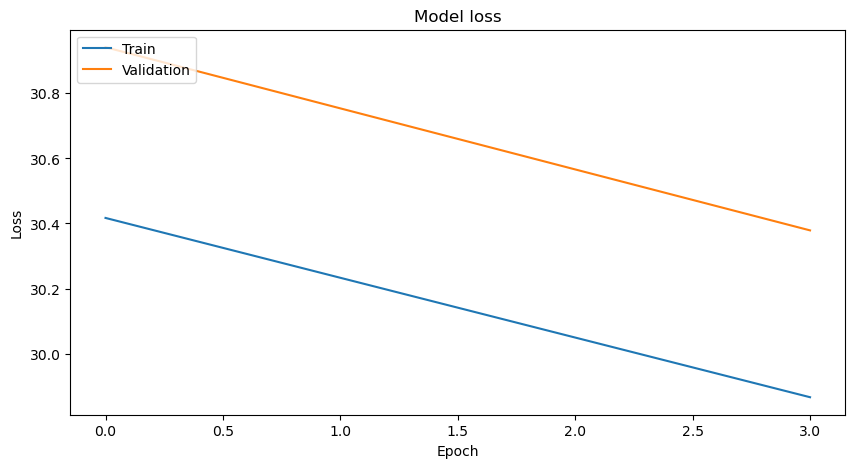

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5000 - loss: 32.3074
Test Loss: 32.307369232177734
Test Accuracy: 0.5


In [43]:

import kagglehub
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# ... (rest of your existing code)

# ... (your existing code up to the model training part)

# Train the model with more epochs and a callback to monitor validation accuracy
# Create a callback to stop training if accuracy doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Add validation data to model.fit
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping]) # Increased epochs


# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [48]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess images
def load_and_preprocess(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (128, 128))  # Resize to a consistent size (adjust if needed)
    img = img / 255.0  # Normalize pixel values
    return img


In [57]:

# Load images and labels
images = []
labels = []
for class_folder in os.listdir(dataset_path):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_file)
            img = load_and_preprocess(image_path)
            if img is not None:
                images.append(img)
                labels.append(1 if class_folder == "Parasitized" else 0)


In [58]:

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [59]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [60]:

# Get image dimensions
image_height, image_width, image_channels = X_train[0].shape


In [61]:


datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [52]:


#More sophisticated model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout for regularization
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model using the image data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Use data augmentation
    epochs=100,  # Increased number of epochs
    validation_data=(X_test, y_test),  # Use separate validation data
    callbacks=[early_stopping]
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 280s 403ms/step - accuracy: 0.5023 - loss: 0.6934 - val_accuracy: 0.5074 - val_loss: 0.6937
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 262s 381ms/step - accuracy: 0.5098 - loss: 0.6931 - val_accuracy: 0.5074 - val_loss: 0.6938
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 282s 409ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.5074 - val_loss: 0.6938
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 307s 445ms/step - accuracy: 0.4995 - loss: 0.6932 - val_accuracy: 0.5074 - val_loss: 0.6937


In [62]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Précision sur les données de test : {test_acc:.2%}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.5033 - loss: 0.6941
✅ Précision sur les données de test : 50.74%
